# Generating a Fibrous Media Network using **VoronoiFibers** from the Materials Module

## Getting Started

In this tutorial, we will demonstrate concepts of random pore network modelling outlined in [J.T. Gostick's 2013 paper](http://jes.ecsdl.org/cgi/doi/10.1149/2.009308jes) and subsequently used in some of our other papers investigating fuel cell gas diffusion layer compression [Tranter et. al 2016](https://onlinelibrary.wiley.com/doi/abs/10.1002/fuce.201500168) and capillary hysteresis [Tranter et. al 2017](http://link.springer.com/10.1007/s11242-017-0973-2). 

## Background

Pores are randomly dispersed inside the domain and connections are defined by the nearest neighbour Delaunay triangulation algorithm. The [Voronoi diagram](https://en.wikipedia.org/wiki/Voronoi_diagram) is the compliment to the [Delaunay triangulation](https://en.wikipedia.org/wiki/Delaunay_triangulation) and is used to replicate the fibres in a porous domain such as a fuel cell GDL. Each pore is surrounded by a cage of fibres which are created from the intersections of the equidistant planes between neighbouring pores. Where the planes intersect, a Voronoi vertex is created. A throat is defined by a set of vertices which are shared by two neighbouring pores. The throat vertices will be coplanar and the throat normal is the vector from one pore's coordinate to the other. N.B this coordinate is not the pore centroid but can be close if the shape of the cage is near spherical. The vertices are used by the Voronoi geometry model which creates a 3D image of the fibres using a supplied fibre radius. Image analysis is then performed to extract pore and throat sizes by using the convex hull of the pore and throat vertices.

## Materials Module
The ``materials`` module was added to OpenPNM in V2.  It solves the problem that often the network topology and the geometry are coupled.  For instance, a sandstone might have an average pore size of 20 um, and they should be spaced apart 100 um.  The pore sizes are dictated by the Geometry class and the spacing is controlled by the Network class.  Thus, in order to get an accurate network model, users must define these both correctly.  The aim of the Materials module was to create a network and geometry at the same time to remove this possible confusion.  Classes in the Materials module actually return a Project object, which contains *both* the network and the geometry, with all properties predefined as needed.  The Voronoi fibers class does this as well.

## Setting up Network and Geometry

We first import the OpenPNM code, including a utility submodule which has useful functions for working with the ```Voronoi``` classes:

In [1]:
import numpy as np
import scipy as sp
import openpnm as op
%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt
np.set_printoptions(5)
%matplotlib inline
np.random.seed(10)

Next we instantiate the ```VoronoiFibers``` classsfrom the **Materials** module, with a few parameters: ```points``` defines the number of pores in the bulk network but some may be removed if the ```fiber_rad``` (radius of the fibers in meters) parameter is large compared with the throat diameters as this will lead to occluded throats and possibly isolated pores. The ```resolution``` parameter sets the size of the voxels in meters used in image generation from which many of the geometry properties derive. The ```shape``` parameter sets the size of the bounding box at which the boundary edges are located and this is positioned with lowest point at the origin. Finally the ```name``` parameter is used to subsequently prefix the name of the additional **Geometry** objects that are created in the process.

In this example we set the random seed in the scipy package to make sure that random points are repeatedly generated with the same values for illustration. This is not necessary, otherwise.

In [2]:
scale = 1e-4
wrk = op.Workspace()
wrk.settings['loglevel'] = 50
wrk.clear()
np.random.seed(1)
proj = op.materials.VoronoiFibers(points=100,
                                  fiber_rad=5e-6,
                                  resolution=1e-6,
                                  shape=[scale, scale, scale],
                                  name='test')

We are returned a handle to the project, which we can see contains three objects.  The network, and two geometries, one for the delaunay pores and one for the voronoi network.  

In [3]:
print(proj)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
 Object Name     Object ID                                                        
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
 test_net        <openpnm.network.DelaunayVoronoiDual object at 0x7f61b1a005e0>   
 test_del        <openpnm.materials.VoronoiFibers object at 0x7f61b1607ea0>       
 test_vor        <openpnm.materials.VoronoiFibers object at 0x7f61b0f1d6d0>       
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


To get access to the geometry objects we must invoke the project object and retrieve them separately

In [4]:
net = proj['test_net']
del_geom = proj['test_del']
vor_geom = proj['test_vor']

As you can see we have more than one geometry. This is because the ```VoronoiFibers``` class has used the ```DelaunayVoronoiDual``` class (covered in another example) which contains pores and throats for the void space in-between fibers assigned to ```del_geom``` and also pores and throats for the fibers themselves which can be used for coupled simulations such as heat transfer assigned to ```vor_geom```. We can at this point delete the pores and throats associated with fibers without impacting the traditional pore network as they are separate and connected by the **interconnect** throats.

In [5]:
from openpnm import topotools as tt
tt.trim(network=net, pores=net.pores('voronoi'))
print(net)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
openpnm.network.DelaunayVoronoiDual : test_net
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
#     Properties                                    Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1     pore.coords                                     226 / 226  
2     throat.conns                                    371 / 371  
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
#     Labels                                        Assigned Locations
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1     pore.all                                      226       
2     pore.back                                     22        
3     pore.bottom                                   25        
4     pore.boundary                                 126       
5     pore.delaunay                   

Note that trimming the **voronoi** pores has also trimmed the **interconnect** and **voronoi** throats as one or both of the pores that the throats connect have been removed, respectively. 

We can now inspect the material visually using some functions on the network object:

/home/anaconda/Code/OpenPNM/openpnm/materials/VoronoiFibers.py:991: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d")


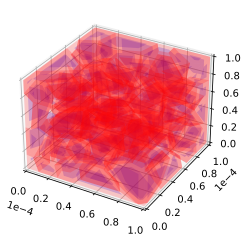

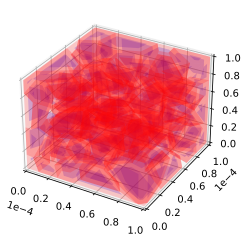

In [6]:
del_geom.plot_pore(pores=del_geom.pores())

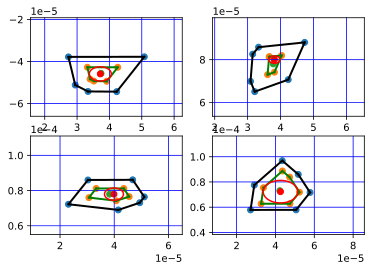

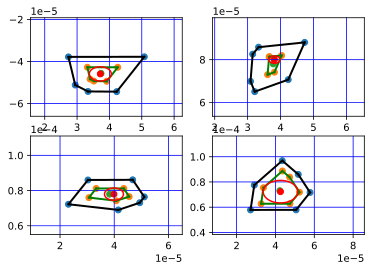

In [7]:
del_geom.plot_throat(throats=del_geom.throats()[:4])

> #### A Note on Boundary Pores
> It is worth mentioning a little about the boundaries at this point. Behind the scenes all the pores in the network were temporarily reflected about the planes confining the pore space during the Delaunay tessellation. This has the effect of creating throats on the outer confines that are aligned with the boundary planes. The boundary pores are labelled ``'surface'`` and can be further identified by the shared coordinate which will either be zero or the values of the domain shape used to initialize the class. As is custom, with openpnm simulations the fictitious boundary pores are assigned zero volume. The pore-size-distribution can be plotted but will be skewed by including the boundary pores:

<Figure size 432x288 with 0 Axes>

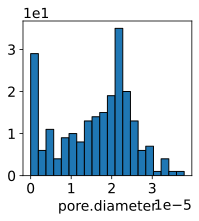

In [8]:
fig = plt.figure()
del_geom.show_hist(props=['pore.diameter'], edgecolor='k')
plt.ticklabel_format(axis="both", style="sci", scilimits=(0,0))

 However, the throats connecting the boundary pores to their neigbors have real non-zero dimensions so the throat-size-distribution looks realistic

<Figure size 432x288 with 0 Axes>

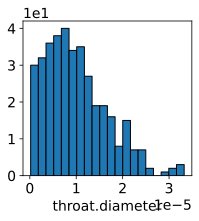

In [9]:
fig = plt.figure()
del_geom.show_hist(props=['throat.diameter'], edgecolor='k')
plt.ticklabel_format(axis="both", style="sci", scilimits=(0,0))

>#### A Note on Performance
> In previous versions of openpnm (1.x) the Voronoi geometry could be generated with the option to use image analysis pore calculations of the pore sizes and other properties, or functions based on using idealized shapes formed from the Voronoi vertices could also be used which is faster but less accurate, especially when dealing with highly anisotropic media. The materials class does not give this option. 
> Generating the voxel image is a memory intensive process relying on many image analysis routines and it is recommended that a smaller network is tested first on your machine whilst monitoring your system performance to gauge whether larger networks are possible.

The image based approach allows for closer inspection of realistic fibrous structures and a few useful functions are provided for analysis and inspection.

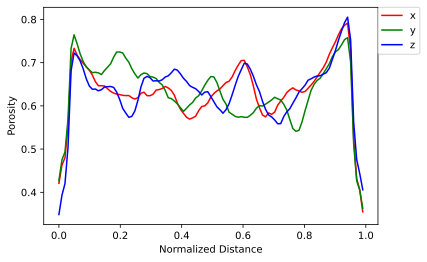

In [10]:
fig = del_geom.plot_porosity_profile()

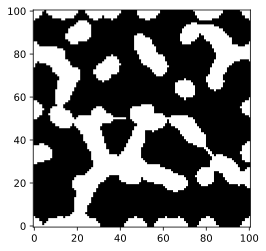

In [11]:
fig = del_geom.plot_fiber_slice(plane=[0, 0.5, 0])

Two images are actually stored as private attributes on the delaunay geometry object: ```_fiber_image``` and ```_hull_image```. The fiber image is a binary image with 1 representing the fiber and 0 the void space. The hull image represents the convex hulls surrounding each pore and is labelled with the original pore index (which may change after trimming). These images can be exported as tiff stacks and visualized in paraview, as well as being used to populate liquid filled porous networks. An example of such an image is shown below and is taken from [Tranter et. al 2016](https://onlinelibrary.wiley.com/doi/abs/10.1002/fuce.201500168)

<img src="https://imgur.com/whiKAVG.png" style="width: 60%" align="left"/>